In [1]:
import pickle
import sys
import csv
import random
sys.path.append(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project')
from execute_remote_scripts import *
# from Processing_Data.downsampling import *
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
%load_ext autoreload
%autoreload 2
# from Server_Scripts.remote_processing_csv import *
from Processing_Data.EDA import *

# Enable LaTeX rendering
plt.rcParams.update({
    "text.usetex": False, 
    "font.family": "serif"
})

C:\Users\Max Tost\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Making the labels for training

In [2]:
random.seed(42) # So that we always work with the same ones.
random_50_re = random.sample(RE_autom, 50)  # Ensures no duplicates

NameError: name 'RE_autom' is not defined

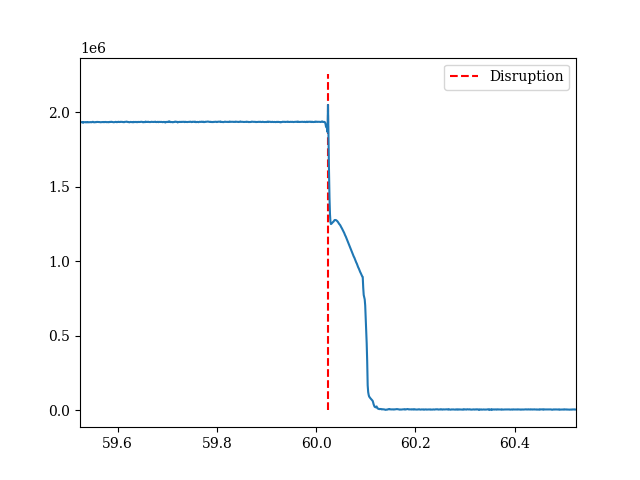

In [43]:
# Shot that is currently processed
#k = 1
#shot_nr = random_50_re[k]
shot_nr = 91076

# Load the file and plot it
base_path_re = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_Files'
file_path = os.path.join(base_path_re, 'JETno' + str(shot_nr)+'.csv')
data = pd.read_csv(file_path)
plt.close()

# Find the first index where time is greater than the starting time + 1
first_index = np.argmax(data['time'] > data['time'][0] + 1)  

# Plot vertical line at this point
plt.vlines(data['time'][first_index], ymin=0, ymax=-data['IPLA'].min()*1.1, color='r', linestyle='dashed', label='Disruption')

plt.plot(data['time'], -data['IPLA'])

# Show the plot
plt.legend()
plt.xlim(data['time'][first_index]-0.5, data['time'][first_index]+0.5)
plt.show()

In [ ]:
# #In case we need to recreate the dictionary
# RE_lifetimes = {}

# np.savez(r"C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\RE_lifetime.npz", **RE_lifetimes)



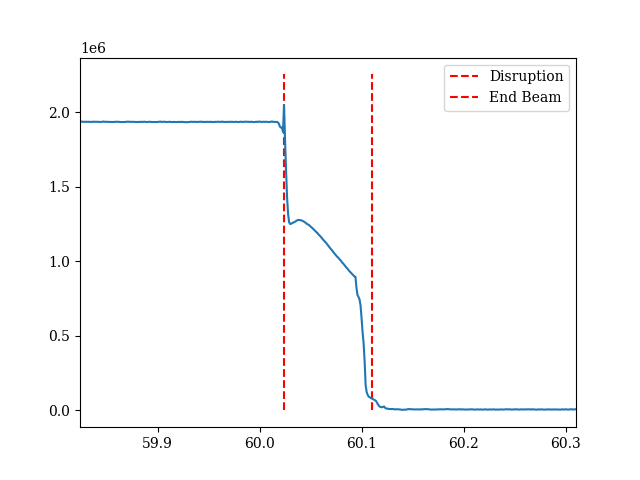

In [52]:
# Set time that is to be written as end of the beam time
end_beam = 60.110

# Load the dictionary
RE_lifetimes = np.load(r"C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\RE_lifetime.npz")
RE_lifetimes = {key: RE_lifetimes[key] for key in RE_lifetimes.files}
# Set the new value and save
RE_lifetimes[f'{shot_nr}'] = (data['time'][first_index], end_beam)
np.savez(r"C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\RE_lifetime.npz", **RE_lifetimes)

# Plot to verify
plt.close()
plt.vlines(data['time'][first_index], ymin=0, ymax=-data['IPLA'].min()*1.1, color='r', linestyle='dashed', label='Disruption')
plt.vlines(end_beam, ymin=0, ymax=-data['IPLA'].min()*1.1, color='r', linestyle='dashed', label='End Beam')
plt.plot(data['time'], -data['IPLA'])

# Show the plot
plt.legend()
plt.xlim(data['time'][first_index]-0.2, end_beam+0.2)
plt.show()

In [53]:
RE_lifetimes

{'91076': (60.0238, 60.11)}

## Plotting data for inspection

In [76]:
base_path_re = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_Files_RE'
files_re = os.listdir(base_path_re)

base_path_no_re = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_Files_NO_RE'
files_no_re = os.listdir(base_path_no_re)
#files_re, files_no_re

# Setting which files from the folders to plot
n = 1
n_no = 3

# Loading them and switching sign of plasma current
data_re = pd.read_csv(os.path.join(base_path_re, files_re[n]))
data_re['IPLA'] = -data_re['IPLA']
data_no_re = pd.read_csv(os.path.join(base_path_no_re, files_no_re[n_no]))
data_no_re['IPLA'] = -data_no_re['IPLA']
data_re.keys(), files_re[n], data_no_re.keys(), files_no_re[n_no]

# Plotting
re, no_re = files_re[n].split('no')[1].split('.')[0], files_no_re[n].split('no')[1].split('.')[0]

# Also setting x limits correctly to see plots     -->                                                                                             #### Here
plot_jet_data(data_no_re, data_re, fr'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\RE{re}_NO_RE{no_re}.svg', (53.5, 54.6), (47.9, 48.5))

(Index(['SSXcore', 'time', 'IPLA', 'DAO_EDG7', 'WMHD', 'RNT', 'DAI_EDG7'], dtype='object'),
 'JETno95732.csv',
 Index(['SSXcore', 'time', 'IPLA', 'DAO_EDG7', 'WMHD', 'RNT', 'DAI_EDG7'], dtype='object'),
 'JETno86646.csv')

## Probability Density Functions of the Data

In [3]:
base_path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_Files_RE'
files = os.listdir(base_path)
# Loading all csv files into a diciotnary
dataframes = {}
for file in files:
    dataframes[int(file.split('.')[0].split('no')[1])] = pd.read_csv(os.path.join(base_path, file))
    
RE_autom = list(pd.read_csv(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\automatic_RE_numbers.csv', header=None)[0])
RE_valid = list(pd.read_csv(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\validated_RE_numbers.csv', header=None)[0])

In [5]:
# Checking for NaNs and Infs and dropping them if necessary
check_nans_infs(dataframes, drop=True)

# Updating the shot lists
RE_autom = [shot for shot in RE_autom if shot in dataframes.keys()]
RE_valid = [shot for shot in RE_valid if shot in dataframes.keys()]
NO_RE_probably = [key for key in dataframes.keys() if key not in RE_autom and key not in RE_valid]

# Extracting the keys of the variables
features = list(dataframes[NO_RE_probably[0]].keys()) #to_numpy()
features.pop(features.index('time'))
features

DataFrame 95732: NaNs = 1408, Infs = 0
DataFrame 95768: NaNs = 1791, Infs = 0
DataFrame 98150: NaNs = 20, Infs = 0
DataFrame 98169: NaNs = 700, Infs = 0
DataFrame 98176: NaNs = 2719, Infs = 0
Dropped DataFrames: [95732, 95768, 98150, 98169, 98176]


IndexError: list index out of range

In [4]:
# Getting the normalised PDFs
RE_features_extrema, RE_features_densities = compute_feature_statistics(dataframes, RE_valid, features)
NO_RE_features_extrema, NO_RE_features_densities = compute_feature_statistics(dataframes, NO_RE_probably, features) 

Error processing feature 'DAI_EDG7' in DataFrame '95774': 'DAI_EDG7'
Error processing feature 'WMHD' in DataFrame '86793': The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Error processing feature 'WMHD' in DataFrame '87722': The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Error processing feature 'WMHD' in DataFrame '90188': The data appears to lie in a lower-dimensional subspace of 

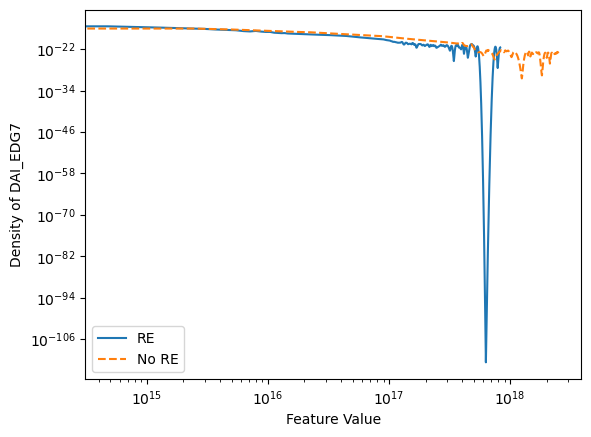

In [6]:
# Plotting and saving them all (log scale optional)
plt.close()
for feature in features:
    plt.close()
    plt.plot(RE_features_densities[feature][0], RE_features_densities[feature][1], label='RE')
    plt.plot(NO_RE_features_densities[feature][0], NO_RE_features_densities[feature][1], '--', label='No RE')
    plt.xlabel('Feature Value')
    plt.ylabel(f'Density of {feature}')
    plt.legend()
    plt.loglog()
    plt.savefig(fr'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\PDFs_DAI\Feature_Density_{feature}_loglog.png')

## Comparing original data with downsampled data

In [14]:
file_original = load_pickle(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\20_random_JET_data.pkl')
original_data = file_original['JETno85000']
downsampled_data = pd.read_csv(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_Files\JETno85000.csv') # These data are downsampled while downloaded

In [16]:
shot=original_data
SSX = shot['SSXcore']
t_b = shot['Ramp_up'][0]
t_e = shot['Ramp_down'][1]
original_time = SSX['time'][(SSX['time'] >= t_b) & (SSX['time'] <= t_e)]
original_data = SSX['signal'][(SSX['time'] >= t_b) & (SSX['time'] <= t_e)]
print(t_b, t_e)

40.917400001490115 59.467300001490116


In [19]:
plt.close()
plt.plot(original_time, original_data)
plt.plot(downsampled_data['time'], downsampled_data['SSXcore'], '-')
plt.show()

<IPython.core.display.Javascript object>

In [20]:
downsampled_data['time'][1]-downsampled_data['time'][0]

0.018568468499999824

In [22]:
original_time[10]-original_time[9]

3.999999999848569e-05